In [8]:
import os
import json
from glob import glob

import torch
import pandas as pd
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import shared.utils as su

In [2]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/Kinetics400"
verb_dir = f"{data_dir}/verbs_in_action"
classes = su.io.load_txt(f"{verb_dir}/classes.txt")
len(classes)

97

In [5]:
from notebooks.eval_care_retrieval import load_model

model_path = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
vfc, tfc, vp  = load_model(_id=model_path)

Loading CaRe model (/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint).  


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


**Encode the text captions**

In [9]:
text_embs = {}
for text in su.log.tqdm_iterator(classes, desc='Computing class embeddings'):
    zt = tfc(text)
    zt = torch.nn.functional.normalize(zt, dim=-1)
    text_embs[text] = zt.cpu().float()
len(text_embs)

Computing class embeddings:   0%|          | 0/97 [00:00<?, ?it/s]

97

Number of unique labels: 97


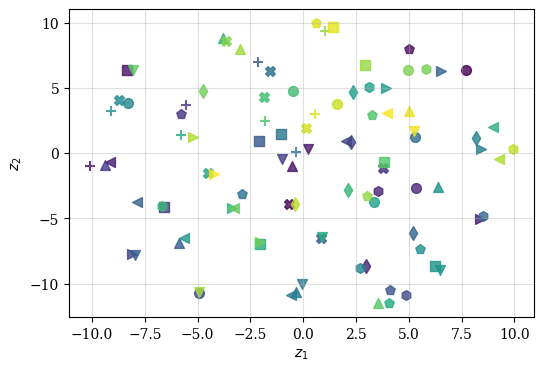

In [14]:
z = torch.stack([text_embs[t] for t in text_embs])
su.visualize.show_projections_with_labels(
    z, labels=classes, legend=False, s=50
)

**Compute video embeddings**

In [17]:
df = pd.read_csv(f"{data_dir}/metadata/val.csv")
df.shape

(19141, 3)

In [36]:
# Pick K videos per class
df = df[df['class'].isin(classes)]
# K = 12
K = 5
subdf = []
for c in classes:
    _df = df[df['class'] == c].sample(n=K, replace=True)
    subdf.append(_df)
subdf = pd.concat(subdf).reset_index(drop=True)
df.shape, subdf.shape

((4619, 3), (485, 3))

In [37]:
video_dir = "/datasets/KineticsClean/"
subdf['path'] = subdf.id.apply(lambda x: f"{video_dir}/{x}.mp4")
subdf = subdf[subdf.path.apply(os.path.exists)]
subdf.shape

(485, 4)

In [38]:
vid_embs = {}
for i in su.log.tqdm_iterator(range(len(subdf))):
    row = subdf.iloc[i].to_dict()
    zv = vfc(vp(row['path']))
    zv = torch.nn.functional.normalize(zv, dim=-1)
    vid_embs[row['id']] = zv
len(vid_embs)

  0%|          | 0/485 [00:00<?, ?it/s]

DECORDError: [01:06:30] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1

In [32]:
ZT = torch.stack([text_embs[text] for text in classes])
ZV = torch.stack([vid_embs[_id] for _id in subdf.id.tolist()])
scores = ZV @ ZT.t()
print(scores.shape)

# Gather predictions for each video
predictions = {}
for i in su.log.tqdm_iterator(range(len(subdf)), desc='Gathering predictions'):
    row = subdf.iloc[i].to_dict()
    scores_i = scores[i]
    predictions[row['id']] = classes[scores_i.argmax().item()].lower()

accuracy = np.mean([predictions[k] == subdf[subdf['id'] == k].iloc[0]['class'] for k in subdf.id.tolist()])
print(f"Accuracy: {accuracy:.2f}")

torch.Size([194, 97])


Gathering predictions:   0%|          | 0/194 [00:00<?, ?it/s]

Accuracy: 0.00
Empty DataFrame
Columns: []
Index: []


ValueError: Expected array-like (array or non-string sequence), got {'val_split/braiding hair/0uswr636GWs_000057_000067': 'braiding hair', 'val_split/braiding hair/-dLVSg5JvxY_000022_000032': 'braiding hair', 'val_split/brushing hair/gaunySZtkzA_000020_000030': 'brushing hair', 'val_split/brushing hair/gkNaCAQyU_0_000034_000044': 'brushing hair', 'val_split/curling hair/IaMtpwudJvk_000061_000071': 'curling hair', 'val_split/curling hair/n7NNDOddJQk_000051_000061': 'curling hair', 'val_split/dying hair/vE6rvDnYHn4_000187_000197': 'getting a haircut', 'val_split/dying hair/bXFlRDV068w_000029_000039': 'fixing hair', 'val_split/fixing hair/JAWLiYCjUog_000003_000013': 'fixing hair', 'val_split/fixing hair/4svnvEa-FjI_000074_000084': 'curling hair', 'val_split/getting a haircut/vaFYLmIqNQ0_000034_000044': 'getting a haircut', 'val_split/getting a haircut/MvNNH4SkkKo_000206_000216': 'eating watermelon', 'val_split/washing hair/OrJ-qtdCN4E_000099_000109': 'washing hair', 'val_split/washing hair/ZpWmwFjw9tY_000166_000176': 'washing hair', 'val_split/doing nails/9DUdNXQQzkU_000056_000066': 'doing nails', 'val_split/doing nails/jTSyr0aHOz4_000067_000077': 'doing nails', 'val_split/cutting nails/tSZsAXi2_wI_000039_000049': 'baby waking up', 'val_split/cutting nails/mPNq5xivemk_000096_000106': 'cutting nails', 'val_split/waxing legs/1e0GSTtyBYU_000000_000010': 'waxing legs', 'val_split/waxing legs/DkshuoeXT_I_000235_000245': 'waxing legs', 'val_split/massaging legs/-drCx9Izr30_000071_000081': 'massaging legs', 'val_split/massaging legs/Ux61o1YRImk_000004_000014': 'massaging back', 'val_split/shaving legs/Ls56e2MvHYE_000301_000311': 'shaving legs', 'val_split/shaving legs/l-LPeSUYjz8_000003_000013': 'shaving legs', 'val_split/stretching leg/jvPvrR-0qJY_000015_000025': 'stretching leg', 'val_split/stretching leg/EmPz4q_Nv7s_000328_000338': 'exercising arm', 'val_split/swinging legs/uoI7gCwHyog_000001_000011': 'exercising arm', 'val_split/swinging legs/asO6bZcU0bY_000013_000023': 'stretching leg', 'val_split/washing hands/UEfeZIXuXeY_000004_000014': 'washing hands', 'val_split/washing hands/U9ADoMTAMjI_000047_000057': 'washing hands', 'val_split/shaking hands/ivgfkFw9HLs_000005_000015': 'shaking hands', 'val_split/shaking hands/hnfqti6NLpA_000004_000014': 'shaking hands', 'val_split/stretching arm/9g2McbQJQJY_000017_000027': 'exercising arm', 'val_split/stretching arm/v_c6axq-cL8_000094_000104': 'exercising arm', 'val_split/exercising arm/-dXJw4nx_fE_000014_000024': 'stretching arm', 'val_split/exercising arm/dbI4Kt6VRn8_000004_000014': 'exercising arm', 'val_split/arm wrestling/669C6dRoCc8_000000_000010': 'arm wrestling', 'val_split/arm wrestling/oG5HTS16p3o_000022_000032': 'arm wrestling', 'val_split/cutting watermelon/CzlmtxREZAw_000115_000125': 'cutting watermelon', 'val_split/cutting watermelon/plZ9i0-pHXE_000030_000040': 'cutting watermelon', 'val_split/eating watermelon/2TAXDQpL9sg_000026_000036': 'eating watermelon', 'val_split/eating watermelon/p2s5fet6Xu0_000068_000078': 'eating watermelon', 'val_split/mopping floor/jntw6lCZIjQ_000004_000014': 'mopping floor', 'val_split/mopping floor/icDRrqhq8KY_000031_000041': 'crawling baby', 'val_split/cleaning floor/7BnwKlUkr4A_000103_000113': 'mopping floor', 'val_split/cleaning floor/G538mW1ifHs_000192_000202': 'mopping floor', 'val_split/sanding floor/UAIJnI7fQYo_000002_000012': 'crawling baby', 'val_split/sanding floor/qQG6TKXcj7E_000019_000029': 'sanding floor', 'val_split/sweeping floor/_FPgOHUU-04_000002_000012': 'sweeping floor', 'val_split/sweeping floor/cFqtKIrpPgk_000051_000061': 'sweeping floor', 'val_split/baby waking up/E90aq2cwCek_000000_000010': 'crawling baby', 'val_split/baby waking up/6Z5GZ-3MrDQ_000005_000015': 'baby waking up', 'val_split/carrying baby/3Q36idyn7g0_000046_000056': 'carrying baby', 'val_split/carrying baby/jIKTg8WTTvk_000197_000207': 'baby waking up', 'val_split/crawling baby/sG73x6Xx1zY_000052_000062': 'crawling baby', 'val_split/crawling baby/KJp_SpYAvN0_000060_000070': 'crawling baby', 'val_split/waxing back/l3HNFa-G3MM_000064_000074': 'waxing back', 'val_split/waxing back/cHYlrNsvQqw_000008_000018': 'waxing back', 'val_split/bending back/DLg2UU3ev1c_000008_000018': 'crawling baby', 'val_split/bending back/kyo_sQgkrBU_000009_000019': 'bending back', 'val_split/massaging back/ikgmpDCWRyk_000093_000103': 'massaging back', 'val_split/massaging back/h8liVGLbERU_000096_000106': 'massaging back', 'val_split/massaging feet/o78dzQaNLIQ_000030_000040': 'shaking hands', 'val_split/massaging feet/Yw1_WkYWPFc_000236_000246': 'massaging legs', 'val_split/washing feet/NnE3hRx35J0_000224_000234': 'washing feet', 'val_split/washing feet/1kVaJjVH8-c_000129_000139': 'washing feet', 'val_split/walking the dog/2Hbz_qxG3qk_000026_000036': 'walking the dog', 'val_split/walking the dog/YNdkvXWaryY_000318_000328': 'walking the dog', 'val_split/grooming dog/5JAzXFCV-Ug_000003_000013': 'curling hair', 'val_split/grooming dog/V8-rdFVhU6U_000096_000106': 'grooming dog', 'val_split/training dog/kw1AWd2VUsc_000187_000197': 'training dog', 'val_split/training dog/d59GjsXi_70_000129_000139': 'training dog', 'val_split/eating cake/sh1DwTqCfec_000049_000059': 'eating cake', 'val_split/eating cake/0pQACKjlllc_000002_000012': 'eating cake', 'val_split/making a cake/3KXf6mKouLc_000119_000129': 'cooking egg', 'val_split/making a cake/_s0jqvtYFb8_000002_000012': 'cooking egg', 'val_split/strumming guitar/gGzoOOi7u-c_000017_000027': 'playing guitar', 'val_split/strumming guitar/1hyVzoP0yQ0_000003_000013': 'playing guitar', 'val_split/playing guitar/ysjCIR7SkJU_000141_000151': 'playing guitar', 'val_split/playing guitar/pf9p9xRQEjA_000100_000110': 'playing guitar', 'val_split/tapping guitar/kKImgfRS8vY_000002_000012': 'playing guitar', 'val_split/tapping guitar/HmX7JiWV-sg_000025_000035': 'playing guitar', 'val_split/shuffling cards/jzOjfk0L9uA_000230_000240': 'shuffling cards', 'val_split/shuffling cards/3zoK4oFSCaE_000005_000015': 'shuffling cards', 'val_split/playing cards/ptTcNRL3c1A_000258_000268': 'shuffling cards', 'val_split/playing cards/CXELciMTioU_000191_000201': 'shuffling cards', 'val_split/wrapping present/LF2MxIo_0Xg_000018_000028': 'wrapping present', 'val_split/wrapping present/EBJkv7GCWU4_000004_000014': 'wrapping present', 'val_split/opening present/1DAtchstb_4_000004_000014': 'opening present', 'val_split/opening present/9nJm_E_TJls_000029_000039': 'opening present', 'val_split/cooking egg/ryn4Zu4zVZ8_000225_000235': 'cooking egg', 'val_split/cooking egg/d_uLBUMJ1NY_000037_000047': 'cooking egg', 'val_split/egg hunting/ZSiemyqY990_000044_000054': 'egg hunting', 'val_split/egg hunting/OKMFSH3Ek_o_000000_000010': 'egg hunting', 'val_split/scrambling eggs/tVB5jD87g4s_000100_000110': 'cooking egg', 'val_split/scrambling eggs/RdZklAZ0K80_000095_000105': 'cooking egg', 'val_split/shining shoes/kFyRVECzFxc_000486_000496': 'shining shoes', 'val_split/shining shoes/ttMkzzndsFg_000439_000449': 'shining shoes', 'val_split/cleaning shoes/saEnBL2Nb1Y_000080_000090': 'cleaning shoes', 'val_split/cleaning shoes/8mRRSBudH3k_000672_000682': 'cleaning shoes', 'val_split/cleaning pool/M9sv9DL3m4w_000096_000106': 'cleaning pool', 'val_split/cleaning pool/3JGPQ3loSV4_000041_000051': 'cleaning pool', 'val_split/jumping into pool/zdscZXp2vvw_000042_000052': 'jumping into pool', 'val_split/jumping into pool/3Q4BgTflA2Q_000005_000015': 'jumping into pool', 'val_split/biking through snow/00cwEcZZcu4_000003_000013': 'biking through snow', 'val_split/biking through snow/Rfihil7FhJ0_000000_000010': 'biking through snow', 'val_split/shoveling snow/DBGea9pST1A_000016_000026': 'shoveling snow', 'val_split/shoveling snow/E0G6Q4C-CMQ_000002_000012': 'shoveling snow', 'val_split/skipping rope/nxDAt9SkPoA_000123_000133': 'skipping rope', 'val_split/skipping rope/CBsQM6oSaPQ_000198_000208': 'skipping rope', 'val_split/climbing a rope/wWPHodWC2DE_000008_000018': 'climbing a rope', 'val_split/climbing a rope/aPJuNSoadcE_000007_000017': 'climbing tree', 'val_split/catching fish/pPrS22Y-CcU_000006_000016': 'ice fishing', 'val_split/catching fish/6M2PO4K78Pg_000002_000012': 'catching fish', 'val_split/feeding fish/PEj8_PhkALw_000002_000012': 'feeding fish', 'val_split/feeding fish/N2JTXWi-Szw_000043_000053': 'feeding fish', 'val_split/filling eyebrows/ms1KF5Syhas_000068_000078': 'filling eyebrows', 'val_split/filling eyebrows/XggaMvJkTa8_000151_000161': 'filling eyebrows', 'val_split/waxing eyebrows/CzBc0KmNMQM_000004_000014': 'waxing eyebrows', 'val_split/waxing eyebrows/PLzR9BxeAoo_000011_000021': 'waxing eyebrows', 'val_split/using computer/D_8O4QoEiQk_000173_000183': 'using computer', 'val_split/using computer/hhf6rX0h-y0_000336_000346': 'washing hands', 'val_split/assembling computer/1HTWTWuiIow_000068_000078': 'assembling computer', 'val_split/assembling computer/aw-ZuNFaaEI_000714_000724': 'assembling computer', 'val_split/climbing tree/D-IkOT6gBAg_000093_000103': 'climbing a rope', 'val_split/climbing tree/-ELsDPpCYkA_000002_000012': 'climbing tree', 'val_split/planting trees/LNzK-tHcxxU_000011_000021': 'shoveling snow', 'val_split/planting trees/Yh94s3ux29k_000060_000070': 'planting trees', 'val_split/trimming trees/THZq7Bwsdeo_000150_000160': 'trimming trees', 'val_split/trimming trees/ZcHBmeOCRUQ_000058_000068': 'climbing tree', 'val_split/driving car/mRx61F5FVFM_000060_000070': 'driving car', 'val_split/driving car/9cbRsJVneGE_000200_000210': 'driving car', 'val_split/pushing car/VoYauMky8IQ_000000_000010': 'pushing car', 'val_split/pushing car/4zZ1JoAv4z4_000021_000031': 'pushing car', 'val_split/golf chipping/8OjV7-vM9PY_000000_000010': 'golf putting', 'val_split/golf chipping/hMV1Bhmxrsc_000003_000013': 'golf putting', 'val_split/golf driving/-L1mPUcEHQY_000000_000010': 'golf chipping', 'val_split/golf driving/VElrGmw_YXA_000079_000089': 'golf chipping', 'val_split/golf putting/EoNbjPOFquY_000106_000116': 'golf putting', 'val_split/golf putting/jDy-xXhQZqE_000009_000019': 'golf chipping', 'val_split/drinking beer/G0XJmZVO8W4_000027_000037': 'drinking beer', 'val_split/drinking beer/to3y0qSS3MU_000007_000017': 'drinking beer', 'val_split/tasting beer/mgcPXbVb_qo_000015_000025': 'tasting beer', 'val_split/tasting beer/UcAAItCUJrk_000518_000528': 'drinking beer', 'val_split/grooming horse/j59F32qbHEg_000088_000098': 'grooming horse', 'val_split/grooming horse/sVrNI39epR0_000545_000555': 'grooming horse', 'val_split/riding or walking with horse/mHDdn4z-cjI_000076_000086': 'grooming horse', 'val_split/riding or walking with horse/t2ZXSVfstOg_000010_000020': 'riding or walking with horse', 'val_split/folding paper/GA5VuyL2uy8_000005_000015': 'folding paper', 'val_split/folding paper/DZtaIMKz0lU_000011_000021': 'folding paper', 'val_split/ripping paper/YNBq000h9uk_000005_000015': 'ripping paper', 'val_split/ripping paper/-Ovwq0kVUx4_000002_000012': 'carrying baby', 'val_split/shredding paper/Mz1n3v-fTbs_000040_000050': 'shredding paper', 'val_split/shredding paper/5-y7AGHsIvM_000019_000029': 'shredding paper', 'val_split/extinguishing fire/INBXVk87-UM_000020_000030': 'extinguishing fire', 'val_split/extinguishing fire/Lzs27USI7Es_000003_000013': 'extinguishing fire', 'val_split/juggling fire/pXeIA1ZHrnk_000045_000055': 'juggling fire', 'val_split/juggling fire/hpwUsBa0VSU_000325_000335': 'juggling fire', 'val_split/shaking head/3L-FGnfvfmE_000001_000011': 'shaking head', 'val_split/shaking head/--8FQVwWH0M_000003_000013': 'carrying baby', 'val_split/shaving head/8do_Cr8ABsM_000200_000210': 'getting a haircut', 'val_split/shaving head/k-FlI2y8lTw_000110_000120': 'getting a haircut', 'val_split/surfing water/CZtMKdIWUdM_000775_000785': 'surfing water', 'val_split/surfing water/-6UpPdfVoyg_000047_000057': 'surfing water', 'val_split/water skiing/Pi_6iAHFEMg_000004_000014': 'surfing water', 'val_split/water skiing/AJYw48_nCOw_000009_000019': 'surfing water', 'val_split/water sliding/xwQmw_alBbU_000002_000012': 'water sliding', 'val_split/water sliding/MRqUHwjukzs_000004_000014': 'jumping into pool', 'val_split/ice climbing/Sn91p3NaFs0_000122_000132': 'ice climbing', 'val_split/ice climbing/kyZGe0Lfocc_000603_000613': 'ice climbing', 'val_split/ice fishing/ozx1kddjwiY_000092_000102': 'ice fishing', 'val_split/ice fishing/E2QZ_ErlrJ4_000022_000032': 'ice fishing', 'val_split/ice skating/9JgcVxfDvjE_000036_000046': 'ice skating', 'val_split/ice skating/T21LaKPZCVI_000069_000079': 'ice skating', 'val_split/dunking basketball/IxnPLK1iczo_000005_000015': 'playing basketball', 'val_split/dunking basketball/N8L8j0RTFdg_000025_000035': 'dunking basketball', 'val_split/dribbling basketball/_cDPlZP2UVw_000004_000014': 'dribbling basketball', 'val_split/dribbling basketball/wCTJ9bKn_sI_000180_000190': 'dribbling basketball', 'val_split/playing basketball/pwCauzvBwJQ_000051_000061': 'playing basketball', 'val_split/playing basketball/MeLrziGSbco_000021_000031': 'playing basketball', 'val_split/shooting basketball/OTbNyKzKBM4_000024_000034': 'playing basketball', 'val_split/shooting basketball/mmGSQfAVPgM_000355_000365': 'playing basketball', 'val_split/drumming fingers/1GqGiu7E5FQ_000060_000070': 'drumming fingers', 'val_split/drumming fingers/kjR6shmDRG8_000081_000091': 'drumming fingers', 'val_split/finger snapping/f0EAjMQX69U_000001_000011': 'climbing tree', 'val_split/finger snapping/KSjL0WCJQ-8_000001_000011': 'finger snapping', 'val_split/catching or throwing baseball/wZy9328QAow_000016_000026': 'skipping rope', 'val_split/catching or throwing baseball/CR0PV8jmGqg_000003_000013': 'hitting baseball', 'val_split/hitting baseball/3R1kvNrGJK0_000011_000021': 'hitting baseball', 'val_split/hitting baseball/e8uB0GZsVOQ_000034_000044': 'hitting baseball', 'val_split/juggling soccer ball/CfBw_K62pxw_000075_000085': 'juggling soccer ball', 'val_split/juggling soccer ball/ke-dI9wQSTk_000038_000048': 'juggling soccer ball', 'val_split/kicking soccer ball/QYplTSs2Orw_000004_000014': 'kicking soccer ball', 'val_split/kicking soccer ball/XVPP91Fy_VY_000001_000011': 'kicking soccer ball'}